In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np

from db import PostgresDB
from schemas import Proband
from matplotlib import pyplot as plt


In [3]:
load_dotenv()


True

In [4]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [5]:
ICU_SCHEMA = "mimiciv_icu"
HOSP_SCHEMA = "mimiciv_hosp"
ED_SCHEMA = "mimiciv_ed"


In [6]:
def create_sepsis_cohort(db: PostgresDB):
    probands = []
    query = """
        SELECT sep.subject_id, sep.stay_id, sta.hadm_id
        FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
        WHERE sep.stay_id = sta.stay_id limit 100;
    """
    db_result = db.execute_query(query)
    for subject_id, stay_id, hadm_id in db_result:
        probands.append(
            Proband(subject_id=subject_id, stay_id=stay_id, hadm_id=hadm_id)
        )
    cohort = Cohort(participants=probands)
    return cohort


In [7]:
from cohorts import Cohort, Proband

sepsis_query = """
    SELECT sep.subject_id, sta.hadm_id
    FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
    WHERE sep.stay_id = sta.stay_id
    ORDER BY RANDOM()
    LIMIT 100;
"""

kdigo_query = """
    SELECT kdigo.subject_id, sta.hadm_id
    FROM mimiciv_derived.kdigo_stages kdigo, mimiciv_icu.icustays sta
    WHERE kdigo.stay_id = sta.stay_id AND kdigo.aki_stage > 2
    ORDER BY RANDOM()
    LIMIT 100;
"""

meld_query = """
    SELECT meld.subject_id, sta.hadm_id
    FROM mimiciv_derived.meld meld, mimiciv_icu.icustays sta
    WHERE meld.stay_id = sta.stay_id AND meld.meld > 32
    ORDER BY RANDOM()
    LIMIT 100;
"""

cardiac_query = """
    SELECT card.subject_id, card.hadm_id
    FROM mimiciv_derived.cardiac_marker card
    WHERE card.hadm_id IS NOT NULL AND card.ntprobnp > 500
    ORDER BY RANDOM()
    LIMIT 100;
"""


In [8]:
COUNT_PER_GROUP = 100

sepsis_pats = db.execute_query(sepsis_query)
meld_pats = db.execute_query(meld_query)
kdigo_pats = db.execute_query(kdigo_query)
card_pats = db.execute_query(cardiac_query)

groups = [sepsis_pats]

participants = []
for group in groups:
    count = 0
    for pat in group:
        if pat[0] not in [p.subject_id for p in participants] and pat[1] not in [
            p.hadm_id for p in participants
        ]:
            participants.append(Proband(subject_id=pat[0], hadm_id=pat[1]))
            count += 1
        if count == COUNT_PER_GROUP:
            break


In [9]:
cohort = Cohort(participants=participants, db=db)


In [10]:
cohort.initialize_data(with_tfidf_diagnoses=True)
result = cohort.compare_encounters(
    demographics_weight=0.0,
    diagnoses_weight=0.0,
    labevents_weight=0.0,
    inputevents_weight=1.0,
    aggregate_method="mean",
    normalize_categories=True,
)


Error executing query: syntax error at or near "FROM"
LINE 2:                 FROM mimiciv_icu.inputevents
                        ^



TypeError: 'NoneType' object is not iterable

In [ ]:
columne_names = [p.hadm_id for p in cohort.participants]
data = [e["similarity"] for e in result]
data = np.array(data).reshape(len(columne_names), len(columne_names))
df = pd.DataFrame(data=data, columns=columne_names, index=columne_names)


In [ ]:
df.shape


(99, 99)

<Axes: >

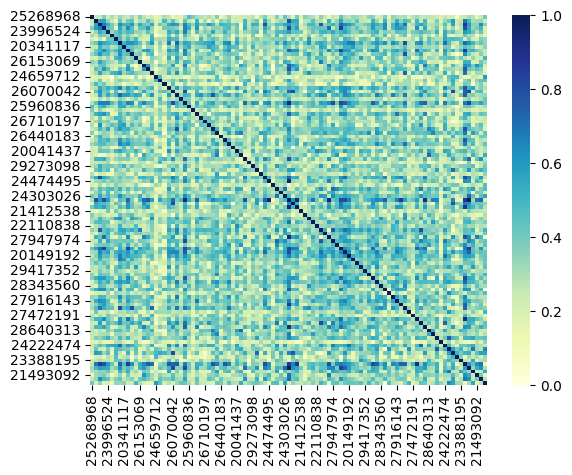

In [ ]:
sns.heatmap(df, cmap="YlGnBu", fmt=".2f")


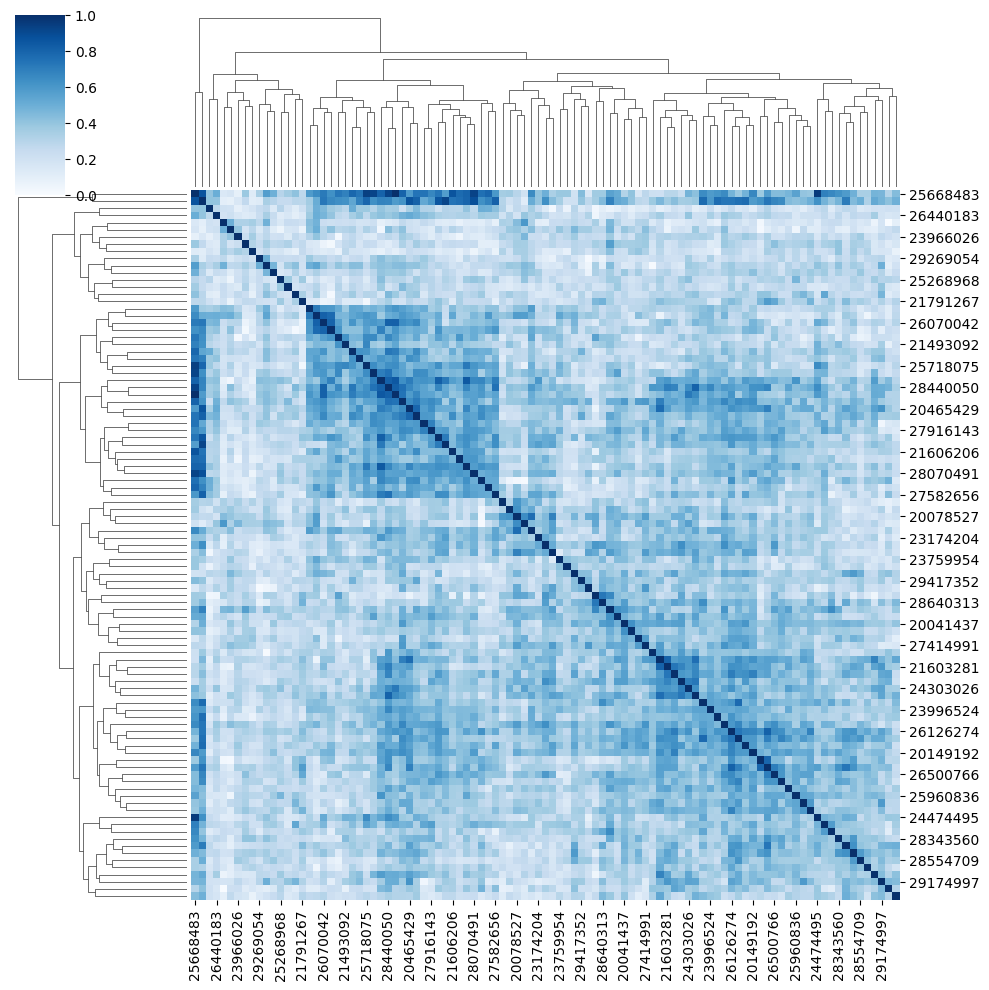

In [ ]:
sns.clustermap(df, annot=False, fmt=".2f", cmap="Blues")


In [ ]:
from sklearn.manifold import MDS


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation


In [ ]:
meld_encounters = [e[1] for e in meld_pats]
sepsis_encounters = [e[1] for e in sepsis_pats]
# kdigo_pats = [e[1] for e in kdigo_pats]
card_pats = [e[1] for e in card_pats]


In [ ]:
N_CLUSTERS = 4
spectral_cluster = SpectralClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", n_init=100
).fit(df)
agglomerative_cluster = AgglomerativeClustering(
    n_clusters=N_CLUSTERS, affinity="precomputed", linkage="average"
).fit(df)
kmeans_cluster = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(df)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(df)
affinity_cluster = AffinityPropagation().fit(df)

clusters = [
    spectral_cluster,
    agglomerative_cluster,
    kmeans_cluster,
    dbscan_cluster,
    affinity_cluster,
]


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
for cluster in clusters:
    print(f"Cluster: {cluster.__class__.__name__}")
    print("------------------")
    for index, group in enumerate(groups):
        print(cluster.labels_[index * COUNT_PER_GROUP : (index + 1) * COUNT_PER_GROUP])
    print("\n")


Cluster: SpectralClustering
------------------
[1 0 0 0 3 1 2 1 1 3 1 2 1 0 0 1 2 2 0 3 0 1 2 0 1 1 0 1 1 1 1 2 0 3 3 2 3
 3 0 2 3 2 2 0 0 2 3 2 1 0 0 0 2 1 1 2 3 1 1 0 3 3 0 0 3 1 3 3 2 3 0 3 1 0
 2 1 0 0 1 2 1 3 1 0 3 2 3 2 3 3 2 2 3 0 0 3 0 0 2]


Cluster: AgglomerativeClustering
------------------
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Cluster: KMeans
------------------
[2 3 1 1 0 0 2 0 0 1 0 2 0 3 1 0 2 2 3 0 3 0 2 1 0 2 1 0 0 0 0 0 3 0 0 2 0
 2 3 2 0 3 2 1 3 2 0 2 0 1 3 1 2 2 0 0 0 0 0 3 0 0 1 1 0 0 0 0 2 0 1 0 0 1
 2 0 1 3 0 2 2 1 0 1 0 2 3 2 0 2 3 2 2 1 1 0 3 3 2]


Cluster: DBSCAN
------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1


/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

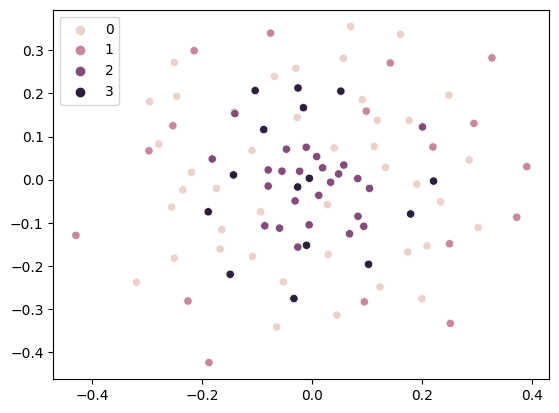

In [ ]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(df)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=kmeans_cluster.labels_, cmap="Set1")


In [ ]:
# plot the los_hosp and los_icu for each cluster in a different scatterplot
def plot_endpoint_for_cluster(
    cohort, cluster, endpoint, x_axis="cluster", hue="cluster", ax=None
):
    y_axis = endpoint
    data = pd.DataFrame(
        {
            x_axis: cluster.labels_,
            y_axis: [getattr(e, endpoint) for e in cohort.participants],
            hue: cluster.labels_,
        }
    )
    if ax is None:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1")
    else:
        sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=data, palette="Set1", ax=ax)


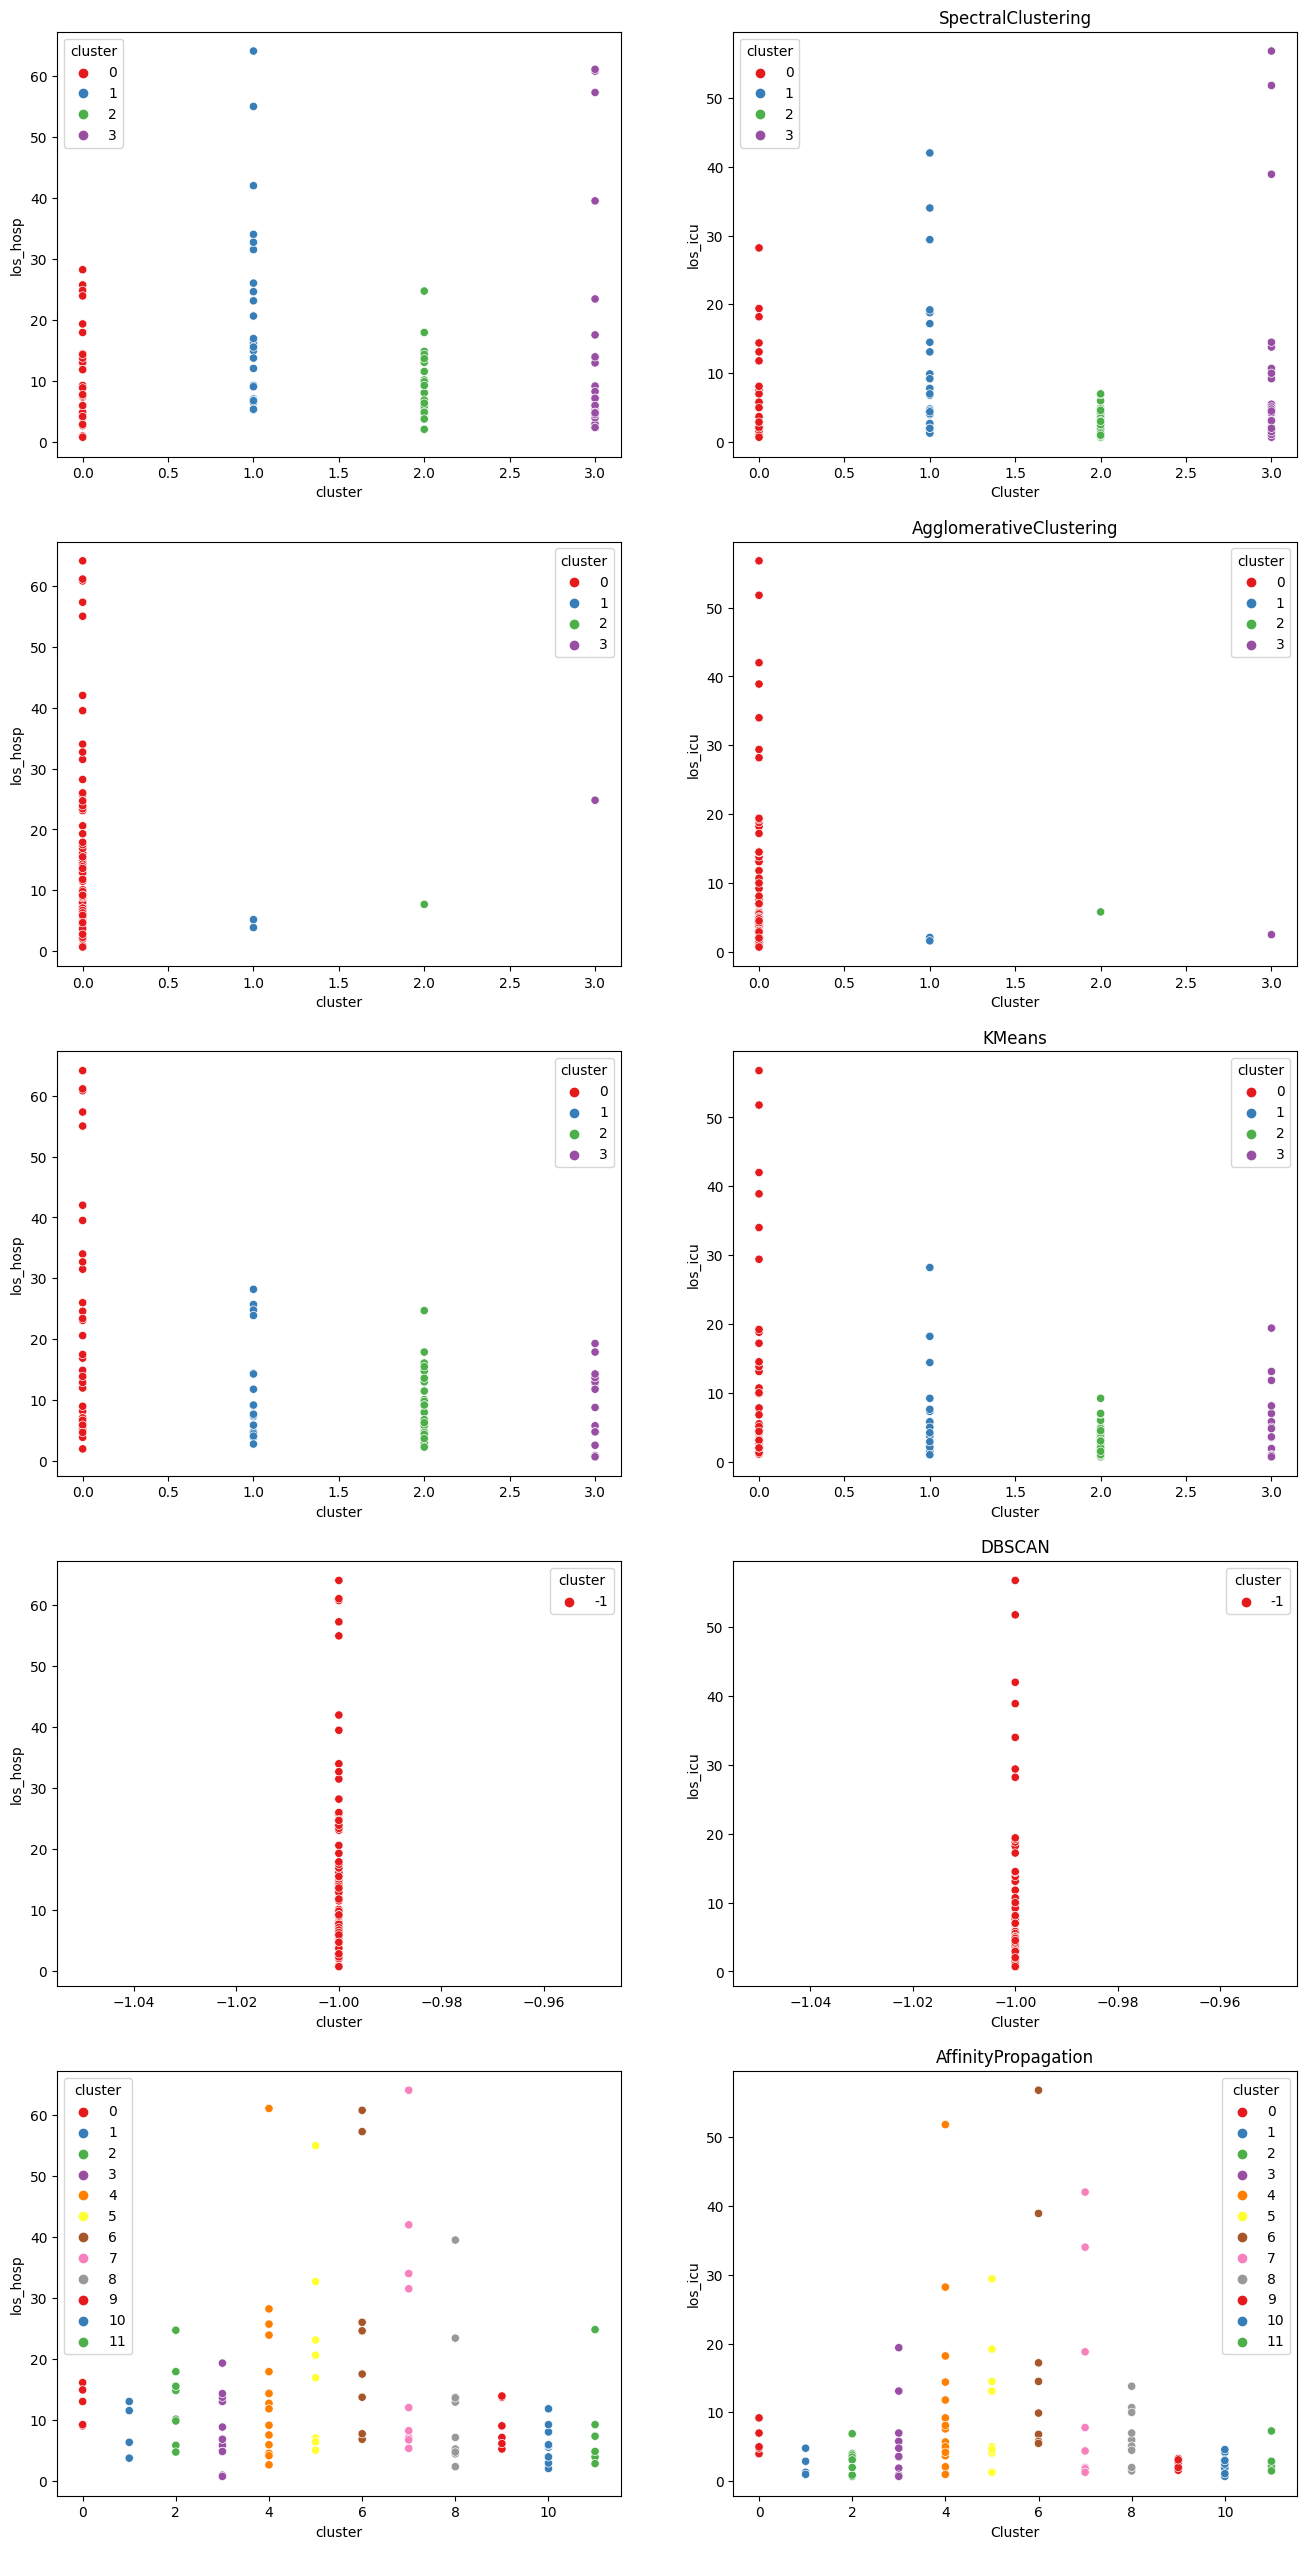

In [ ]:
endpoints = ["los_hosp", "los_icu"]

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=len(clusters), ncols=2, figsize=(16, 32))

for col, cluster in enumerate(clusters):
    for row, endpoint in enumerate(endpoints):
        plot_endpoint_for_cluster(
            cohort,
            cluster,
            endpoint,
            x_axis="cluster",
            hue="cluster",
            ax=axes[col][row],
        )
    axes[col][row].set_title(cluster.__class__.__name__)
    axes[col][row].set_xlabel("Cluster")
    axes[col][row].set_ylabel(endpoint)
